In [3]:
%pylab inline
from pathlib import Path

import keras.backend as K
from keras import Input, Model
from keras.layers import Lambda, LSTM, Dense, TimeDistributed
from keras.optimizers import Adam
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['concatenate']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [8]:
normalized_transactions_filepath = Path('../../datasets/berka_dataset/usable/normalized_transactions_100.npy')
generated_transactions_filepath = Path('../generative_models/wgan/2018-04-22_18-38-39/generated_datasets/last.npy')

timesteps = 100
train_data = np.load(generated_transactions_filepath)[:30000]
test_data = np.load(normalized_transactions_filepath)[:10000]

print(train_data.shape)
print(test_data.shape)

(30000, 100)
(10000, 100)


In [9]:
class PredictiveModel:
    def __init__(self, timesteps):
        self._timesteps = timesteps
        
    def build_model(self, lr):
        optimizer = Adam(lr=lr, clipnorm=1.0)
        model_inputs = Input((self._timesteps,))
        
        prediction = Lambda(lambda x : K.expand_dims(x))(model_inputs)
        prediction = LSTM(8, return_sequences=True)(prediction)
        prediction = TimeDistributed(Dense(1, activation='tanh'))(prediction)
        prediction = Lambda(lambda x : K.squeeze(x, -1))(prediction)
        
        self._model = Model(model_inputs, prediction)
        self._model.compile(loss='mse', optimizer=optimizer)
        return self._model
    
    def train(self, epochs, x_train, y_train, x_val, y_val):
        self._model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs)

In [10]:
x_train = train_data[:,:-1]
y_train = train_data[:, 1:]

x_val = test_data[:, :-1]
y_val = test_data[:, 1:]

lr = 0.01
epochs = 30

In [11]:
predictive_model = PredictiveModel(timesteps-1)
model = predictive_model.build_model(lr)
predictive_model.train(epochs, x_train, y_train, x_val, y_val)

Train on 30000 samples, validate on 10000 samples
Epoch 1/30
 9856/30000 [========>.....................] - ETA: 1:54 - loss: 0.0866

KeyboardInterrupt: 

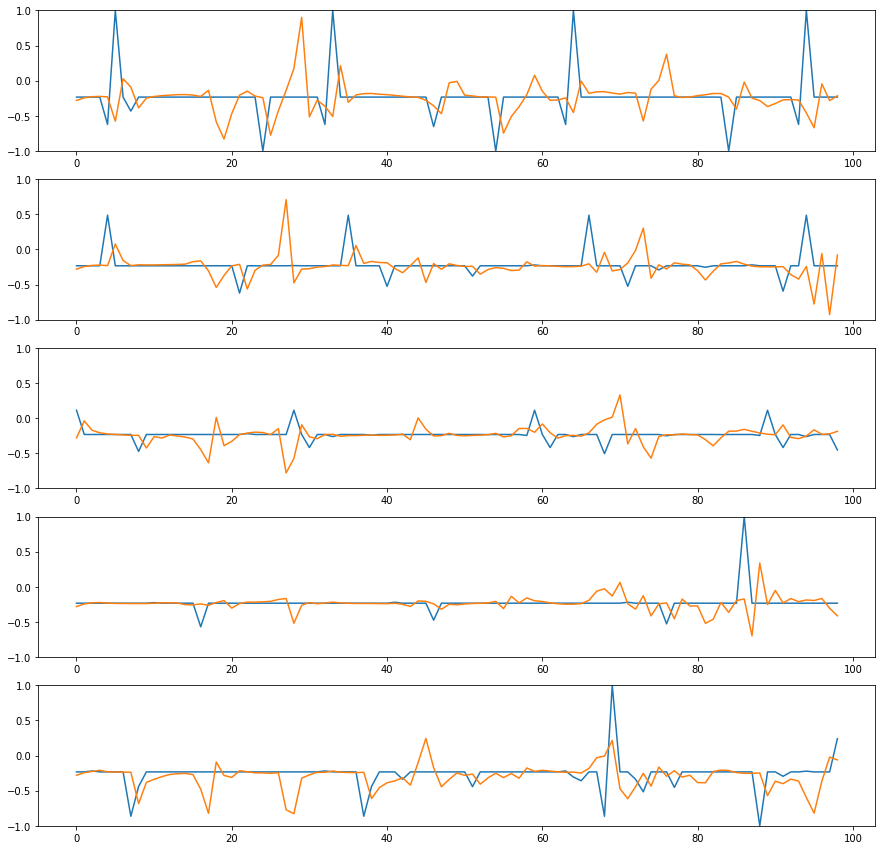

In [15]:
samples = 5
indexes = np.random.choice(10000, samples)

plt.subplots(samples, 1, figsize=(15, 3*samples))
for i, index in enumerate(indexes):
    plt.subplot(samples, 1, i+1)
    plt.plot(y_val[index])
    plt.plot(model.predict(x_val[index:index+1]).T)
    plt.ylim(-1, 1)
plt.show()